In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pathlib import Path
data_dir = Path("./../data")
df = pd.read_csv(data_dir.joinpath("./adult_train.csv"))
test = pd.read_csv(data_dir.joinpath("./adult_test.csv"))
test

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [3]:
num_cols = list(df.select_dtypes("number"))
target_col = ["income_bracket"]
total_cols = num_cols + target_col
data = df[total_cols]
y = data.pop(target_col[0])
X = data

In [4]:
input_dim = X.shape[1]
feature_dim = 20

In [5]:
from ndf import FeedForward , NeuralDecisionForest ,Forest

feature_layer = FeedForward(
    input_dim=input_dim, output_dim=feature_dim, layers=[25, 25], activation="tanh", bn="batch_norm", last_logit=True
)
forest_param = dict(
    n_tree=5, tree_depth=3, n_in_feature=feature_dim, tree_feature_rate=0.5, n_class=2, jointly_training=True
)
forest = Forest(**forest_param)
nnForest = NeuralDecisionForest(feature_layer=feature_layer, forest=forest)

In [13]:
import torch  #X
x_tensor = torch.tensor(X.values,dtype=torch.float32)
x_tensor_sample = x_tensor[[0,1,2,3,4,5],:]
nnForest(x_tensor_sample)

tensor([[0.5018, 0.4982],
        [0.5017, 0.4983],
        [0.4913, 0.5087],
        [0.4892, 0.5108],
        [0.4865, 0.5135],
        [0.4870, 0.5130]], grad_fn=<DivBackward0>)

In [46]:
def prepare_optim(model, lr):
    params = [p for p in model.parameters() if p.requires_grad]
    return torch.optim.Adam(params, lr=lr, weight_decay=1e-5)

In [15]:
X.values , y.values

(array([[    39,  77516,     13,   2174,      0,     40],
        [    50,  83311,     13,      0,      0,     13],
        [    38, 215646,      9,      0,      0,     40],
        ...,
        [    58, 151910,      9,      0,      0,     40],
        [    22, 201490,      9,      0,      0,     20],
        [    52, 287927,      9,  15024,      0,     40]]),
 array([' <=50K', ' <=50K', ' <=50K', ..., ' <=50K', ' <=50K', ' >50K'],
       dtype=object))

In [45]:
from sklearn.preprocessing import LabelEncoder
import numpy as np 

In [56]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset): 
  
  def __init__(self, x, y) :    
      self.x_numpy =x  
      self.encoder = LabelEncoder()
      unique_label = set(y)
      try :
          unique_label.remove(np.nan)
      except KeyError as e :
          pass 
        
      self.encoder.fit(list(unique_label))
      self.y_numpy = self.encoder.transform(y)
      if self.y_numpy.ndim == 1 :
          self.y_numpy = self.y_numpy[:,None]
      
      self.target2idx = {idx:label for idx , label in enumerate(self.encoder.classes_)}
      self.idx2target = {v:k for k , v in target2idx.items()}

  # 총 데이터의 개수를 리턴
  def __len__(self): 
      return len(self.x_numpy)
  
  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
  def __getitem__(self, idx): 
      x = torch.FloatTensor(self.x_numpy[idx])
      y = torch.FloatTensor(self.y_numpy[idx])
      return x, y

dataset = CustomDataset(data.values , y.values)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [57]:
optim = prepare_optim(nnForest, 1e-3)
batch_x , batch_y = next(iter(dataloader))

In [58]:
output = nnForest(batch_x)
output

tensor([[0.4868, 0.5132],
        [0.5006, 0.4994]], grad_fn=<DivBackward0>)

In [126]:
class ClassificationMetric(object) :
    

    def __init__(self,metric_kwargs={}) :
        self.metrics= [torchmetrics.classification.F1(**metric_kwargs),
                    #    torchmetrics.AUC(**metric_kwargs),
                       torchmetrics.classification.Accuracy(**metric_kwargs),
                       torchmetrics.classification.AveragePrecision(**metric_kwargs),
                       torchmetrics.classification.AUROC(**metric_kwargs),
                       torchmetrics.classification.FBeta(beta=0.5,**metric_kwargs)
                       ]

        self.metric_dict = {type(metric).__name__:metric  for metric in self.metrics}
        self.reset_log()
    
    def reset(self,) :
        for name , metric in self.metric_dict.items() :
            metric.reset()
    
    def update(self, pred , target) :
        for name , metric in self.metric_dict.items() :
            metric.update(pred ,target)
            
            
    def compute(self,to_numpy=True) :
        result_dict = {}
        for name , metric in self.metric_dict.items() :
            if to_numpy : 
                result = metric.compute().detach().numpy()
            else :
                result = metric.compute() 
            result_dict[name] = result
        return result_dict 
    
    def log(self, result_dict) :
        for name , metric in result_dict.items() :
            self.history[name].append(metric)
    
    def reset_log(self,) :
        self.history = {type(metric).__name__:[]  for metric in self.metrics}
        
        
        

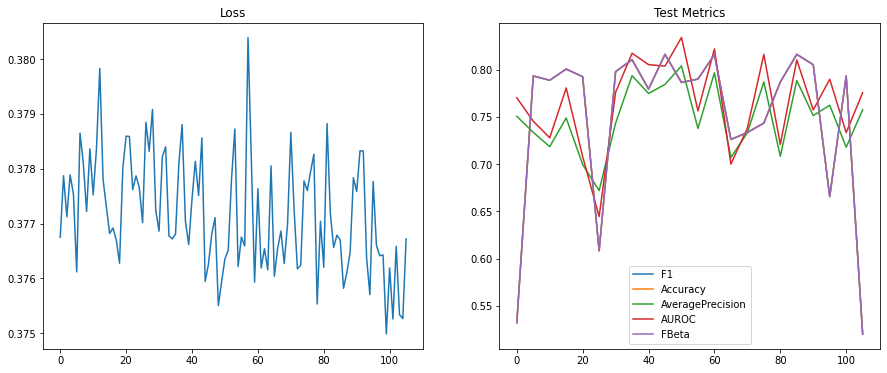

In [128]:
import torchmetrics 
import matplotlib.pyplot as plt 
from IPython.display import clear_outputimport torch.nn.functional as F
import matplotlib.pyplot as plt 

def train(model, optim, dataset, **kwargs) :
    Loss_Collection = dict(train=[],test=[],loss=[])
    metric = torchmetrics.F1()
    metrics  = ClassificationMetric(metric_kwargs=dict(num_classes=2))
    for epoch in range(0,kwargs.get("n_epoch",100)) :
        model.train()
        trainloader = DataLoader(dataset, batch_size=kwargs.get("batch_size",32), shuffle=kwargs.get("shuffle",True))
        Loss = []
        metric.reset()
        for batch_idx, (batch_x, batch_y) in enumerate(trainloader):
            output = nnForest(batch_x)
            optim.zero_grad()
            loss = F.nll_loss(torch.log(output), batch_y.squeeze().long())
            loss.backward()
            optim.step()
            Loss.append(loss.detach().numpy())
            metric(output, batch_y.squeeze().long())
        f1 = metric.compute()
        Loss_Collection["loss"].append(np.mean(Loss))
        Loss_Collection["train"].append(f1*100)
        if epoch % kwargs.get("n_log",5) == 0 :    
            clear_output(wait=True)
            evalloader = DataLoader(dataset, batch_size=kwargs.get("batch_size",32), shuffle=False)
            
            metric.reset()
            model.eval()
            metrics.reset()
            for batch_idx, (batch_x, batch_y) in enumerate(evalloader):
                output = nnForest(batch_x)
                metric(output, batch_y.squeeze().long())
                metrics.update(output, batch_y.squeeze().long())
            else :
                result = metrics.compute()
                metrics.log(result)
                f1 = metric.compute()
            Loss_Collection["test"].append(f1*100)
            fig , ax = plt.subplots(1,2,figsize=(15,6))
            axes = ax.flatten()
            logs_iter = [ i * kwargs.get("n_log",5) for i in range(len(Loss_Collection["test"]))]
            axes[0].plot(Loss_Collection["loss"])
            for metric_name , value in metrics.history.items() :
                axes[1].plot(logs_iter , value ,label=metric_name)
            #axes[1].plot(Loss_Collection["train"],label="train")
            #axes[1].plot(logs_iter,  Loss_Collection["test"],label = "test")
            axes[0].set_title("Loss")
            title = f"{type(metric).__name__} train best : {np.max(Loss_Collection['train']):.2f} test best : {np.max(Loss_Collection['test']):.2f}"
            axes[1].set_title("Test Metrics")
            plt.legend()
            plt.show()
train(nnForest , optim , dataset,batch_size=512,n_epoch=1000)
        
        